In [891]:
import pandas as pd
import yfinance as yf
import pandas_market_calendars as mcal
import yfinance as yf
from datetime import datetime
import numpy as np

# Objective: Determine if model that classifies an industry/date as an 'invest day' helps the performance of stocks chosen by relative strength program.  
**The model classifies a date/industry as invest or don't invest.  I will evaluate the models performance in two ways**
* *Compare the average percent of dates/industries classified as non invest with those classified as invest*
* *Compare the performance of an investment portfolio simulation before an after the model is used.*

# The Data
**&emsp; 2.5 years of stock data.  The stocks were selected from a relative strength program..  The relative strength program is described in other notebooks.  You will see reference to three different strategies: Slope, Corr, and Product.  You can think of these as three different portfolios containing different stocks.**


**Three data sets**
* **df20:** *Dates go by periods of 20 days.  The program generates stocks to invest in (for each strategy) and are held for 20 days, at which point the program is run again and new stocks are determined.
* **df20_all:** *Dates go by periods of 1 day.  The program generates new stocks to invest in each day.  These are also held for 20 days.*
* **df_action:** *This is the data that contains columns that indicate whether a particular date/industry should be invested in.  The values of the action column were generated by an xgBoost model.  The model details are shown in other notebooks.*

In [894]:
nyse = mcal.get_calendar('NYSE')
def get_end_date(start, periods=20):
    end_date = pd.Timestamp(start) + pd.Timedelta(days=periods * 2)
    trading_days = nyse.valid_days(start_date=start, end_date=end_date)

    if len(trading_days) < periods:
        print(f"Not enough trading days from {start}")
        return None
    print(start)
    print(trading_days[periods-1].strftime('%Y-%m-%d'))
    return trading_days[periods-1].strftime('%Y-%m-%d')

def get_one_day(ticker, date):
    data = yf.download(ticker, start=date, end=pd.to_datetime(date) + pd.Timedelta(days=1))
    try:
        day = data['Adj Close'].values[0]
    except IndexError:
        try:
            data= yf.download(ticker, start=date, end=pd.to_datetime(date) + pd.Timedelta(days=2))
            day = data['Adj Close'].values[0]
        except:
            day = np.nan
            print(f"No data for {ticker} on {date}")
    return day

def get_difference(ticker, start, periods=20):
    end_date = get_end_date(start, periods=periods)
    
    if end_date is None:
        return pd.Series([np.nan, np.nan, np.nan])
    
    before = get_one_day(ticker, start)
    after = get_one_day(ticker, end_date)
    
    if np.isnan(before) or np.isnan(after):
        return pd.Series([before, after, np.nan])
    
    return pd.Series([before, after, (after-before)/before])

RERUN = False
period=20
if RERUN:
    df20_all=pd.read_csv(f'best_stocks_20_trading_day_period_alldays.csv')
    df20_all[['Start_Close', '20_days Close', 'Percent Gain']] = df20_all.apply(
    lambda x: get_difference(x['Stock'], x['End Date'],periods=period), axis=1)
    df20_all.to_csv(f'Best_stocks_next_{period}_days_all_days.csv', index=False)
    
    df20=pd.read_csv(f'best_stocks_20_trading_day.csv')
    df20[['Start_Close', '20_days Close', 'Percent Gain']] = df20.apply(
    lambda x: get_difference(x['Stock'], x['End Date'],periods=period), axis=1)
    df20.to_csv(f'Best_stocks_next_{period}_days.csv', index=False)


else:
    print('Read from csv (already has data for the holding period of 20 days ahead of the end_date)')
    df20_all=pd.read_csv(f'Best_stocks_next_{period}_days_all_days.csv')
    df20 = pd.read_csv(f'Best_stocks_next_{period}_days.csv')
    print('You are using 20 day investment periods')
    df20=df20.dropna()
    df20.info()

Read from csv (already has data for the holding period of 20 days ahead of the end_date)
You are using 20 day investment periods
<class 'pandas.core.frame.DataFrame'>
Index: 864 entries, 0 to 881
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Start Date     864 non-null    object 
 1   End Date       864 non-null    object 
 2   Metric         864 non-null    object 
 3   Industry       864 non-null    object 
 4   Stock          864 non-null    object 
 5   Stock_Rank     864 non-null    int64  
 6   Industry_Rank  864 non-null    int64  
 7   Start_Close    864 non-null    float64
 8   20_days Close  864 non-null    float64
 9   Percent Gain   864 non-null    float64
dtypes: float64(3), int64(2), object(5)
memory usage: 74.2+ KB


# What the data looks like

In [896]:
df20[df20['Metric']=='Slope'].head(5)

,Start Date,End Date,Metric,Industry,Stock,Stock_Rank,Industry_Rank,Start_Close,20_days Close,Percent Gain
0,2022-01-03,2022-02-01,Slope,XLE,EOG,1,1,98.842262,101.663101,0.028539
1,2022-01-03,2022-02-01,Slope,XLE,COP,2,1,82.350212,87.664856,0.064537
2,2022-01-03,2022-02-01,Slope,XLE,SLB,3,1,37.746002,36.091072,-0.043844
3,2022-01-03,2022-02-01,Slope,XLP,PM,1,2,90.319290,88.735970,-0.017530
4,2022-01-03,2022-02-01,Slope,XLP,PG,2,2,149.996552,143.958740,-0.040253


In [897]:
df20[df20['Metric']=='Corr'].head(5)

,Start Date,End Date,Metric,Industry,Stock,Stock_Rank,Industry_Rank,Start_Close,20_days Close,Percent Gain
297,2022-01-03,2022-02-01,Corr,XLE,EOG,1,1,98.842278,101.663078,0.028538
298,2022-01-03,2022-02-01,Corr,XLE,SLB,2,1,37.745995,36.091068,-0.043844
299,2022-01-03,2022-02-01,Corr,XLE,XOM,3,1,73.296562,72.587143,-0.009679
300,2022-01-03,2022-02-01,Corr,XLP,PM,1,2,90.319283,88.735954,-0.017530
301,2022-01-03,2022-02-01,Corr,XLP,MO,2,2,41.052578,41.806507,0.018365


In [898]:
df20[df20['Metric']=='Product'].head(5)

,Start Date,End Date,Metric,Industry,Stock,Stock_Rank,Industry_Rank,Start_Close,20_days Close,Percent Gain
594,2022-01-03,2022-02-01,Product,XLE,EOG,1,1,98.842262,101.663094,0.028539
595,2022-01-03,2022-02-01,Product,XLE,COP,2,1,82.350220,87.664848,0.064537
596,2022-01-03,2022-02-01,Product,XLE,SLB,3,1,37.746002,36.091068,-0.043844
597,2022-01-03,2022-02-01,Product,XLP,PM,1,2,90.319290,88.735970,-0.017530
598,2022-01-03,2022-02-01,Product,XLP,MO,2,2,41.052574,41.806499,0.018365


# df20 All has more days

In [900]:
df20_all[df20_all['Metric']=='Product'].head(5)

,Start Date,End Date,Metric,Industry,Stock,Stock_Rank,Industry_Rank,Stock_Metric_Sign,Start_Close,20_days Close,Percent Gain
11484,2022-01-03 00:00:00,2022-02-01,Product,XLE,EOG,1,1,True,113.180000,116.410004,0.028539
11485,2022-01-03 00:00:00,2022-02-01,Product,XLE,COP,2,1,True,91.081856,96.959999,0.064537
11486,2022-01-03 00:00:00,2022-02-01,Product,XLE,SLB,3,1,True,39.397327,37.669998,-0.043844
11487,2022-01-03 00:00:00,2022-02-01,Product,XLP,PM,1,2,True,103.250000,101.440002,-0.017530
11488,2022-01-03 00:00:00,2022-02-01,Product,XLP,MO,2,2,True,50.639999,51.570000,0.018365


**Variable Explanation**
* **20_days_Close** *Represents the closing price after the holding period.*
* **Percent Gain** *Represents the percent gain attained at the end of the holding period.*
* **End Date** *Represents the day investment date.*
* **Start Date** *Represents when the back period began. The date that the relative strength values were generated from**
* **Metric** *Represents the strategy that was used to decide the industry and stock.*
* **Industry_Rank** *Represents the industry rank according to the relative strength program*
* **Stock_Rank** *Represents the stock rank within the chosen industry, according to the relative strength program.*

# Load csv with action data. 

In [903]:
import joblib
df_action=pd.read_csv('Action_Data.csv')


**Ensure date formats are the same**

In [905]:
df20['End Date']=pd.to_datetime(df20['End Date']).dt.date
df_action['Date']=pd.to_datetime(df_action['Date']).dt.date

In [960]:
def get_action(date,df_action):  
    try:
        if int(df_action[df_action['Date']==date]['Predicted_Action'].values[0])==1:
            return True
    except:
        return True
    else:
        return False
def get_action2(date,df_action):  
    try:
        if df_action[df_action['Date']==date]['isDecreasing'].values[0]==0:
            return True
    except:
        return True
    else:
        return False
def get_action3(date, ind_ticker, df_action,action_column='Predicted_Action'):
    try:
        if int(df_action[(df_action['Date']==date)&(df_action['Ticker']==ind_ticker)][action_column].values[0])==1:
            return True
        else:
            return False
            
    except:
        return True

def get_action4(date,ind_ticker,df_action,ticker_columns,action_column='Predicted_Action2'):
    for col in ticker_columns:
        if ind_ticker in col:
            COLUMN=col
    try:
        if int(df_action[(df_action[COLUMN])&(df_action['Date']==date)][action_column].values[0])==1:
            return True
        else:
            return False
            
    except:
        return True
ticker_cols=[col for col in df_action.columns if 'Ticker' in col]
df20['Action']=df20.apply(lambda x: get_action4(x['End Date'],x['Industry'],df_action,ticker_cols,action_column='Predicted_Action2'),axis=1)
df20_all['End Date']=pd.to_datetime(df20_all['End Date']).dt.date
df20_all['Action']=df20_all.apply(lambda x: get_action4(x['End Date'],x['Industry'],df_action,ticker_cols,action_column='Predicted_Action2'),axis=1)
                                          

In [907]:
df20['Action'].value_counts()

Action
True     771
False     93
Name: count, dtype: int64

*The model finds that there are 93 occurences of industries that should not be invested on particular dates.*

# Investment Simulation 
**&emsp;Simulate starting with $1000 and investing 65% into top ranked industry/stock, 20% into the second ranked industry/stock, and 15% into the third ranked industry stock. For example, 1000X0.65X0.65 will be invested into the top ranked stock from the top ranked industry.   The amount invested is recalibrated after each 20 day holding period.**

In [910]:
def get_breakdown(invest):
    schedule={1: 0.65*invest,
            2: 0.20*invest,
            3: 0.15*invest}
    return schedule
def Invest(df,ignore_action=True):
    metrics=['Slope','Corr','Product']
    stock_percentages={1:0.65, 2: 0.20,3:0.15}
    D={}
    values={metric:[] for metric in metrics}
    dates={metric: [] for metric in metrics}
    for metric in metrics:
        invest=1000
        value=invest
        data=df[df['Metric']==metric].sort_values(by='End Date')
        schedule=get_breakdown(value)
        for ind, row in data.iterrows():
            if not ignore_action:
                if row['Action']:
                    value+=schedule[row['Industry_Rank']]*stock_percentages[row['Stock_Rank']]*row['Percent Gain']
                    schedule=get_breakdown(value)
            else:
                value+=schedule[row['Industry_Rank']]*stock_percentages[row['Stock_Rank']]*row['Percent Gain']
                schedule=get_breakdown(value)
            if value<0:
                add_amount=abs(value)+1000
                value+=add_amount
                invest+=add_amount
            values[metric].append(value)
            dates[metric].append(pd.to_datetime(row['End Date']))
        D[metric]=[invest,value]
    print('Summary')
    print()
    print('{:<25}{:<25}{:<25}'.format('Strategy','Amount Invested', 'Value after 2.5 years'))
    for key, value in D.items():
        print('{:<25}{:<25}{:<25}'.format(key,value[0], value[1]))
    return D, values, dates



In [911]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_vs_market(df,values,dates,strategy='Corr',holding_period=10):
    start_date = '2022-01-01'
    end_date = datetime.today().strftime('%Y-%m-%d')
    # Fetch VOO data
    voo = yf.Ticker("VOO")
    df_voo= voo.history(start=start_date, end=end_date).reset_index()
    df_voo['Date']=pd.to_datetime(df_voo['Date']).dt.date
    df['End Date']=pd.to_datetime(df['End Date']).dt.date
    df_voo_reduced=df_voo[df_voo['Date'].isin(df['End Date'].unique())]
    df_voo_reduced=df_voo_reduced.sort_values(by='Date')
    df_voo_reduced['Pct_Change'] = (df_voo_reduced['Close'] - df_voo_reduced['Close'].shift(1)) / df_voo['Close'].shift(1) 
    
    print("\nAlternative percentage change calculation:")
    df_voo_reduced[['Date', 'Close', 'Pct_Change']].head()
    invest=1000
    value=invest
    dates_voo=[]
    values_voo=[]
    for ind,row in df_voo_reduced.iterrows():
        if pd.isna(row['Pct_Change']):
            dates_voo.append(row['Date'])
            values_voo.append(invest)
        else:
            value=value+value*row['Pct_Change']
            dates_voo.append(row['Date'])
            values_voo.append(value)
    
    fig, ax=plt.subplots()
    ax.scatter(x=dates[strategy],y=values[strategy], color='blue',label='Portfolio')
    ax.scatter(x=dates_voo,y=values_voo,color='red',label='Market')
    ax.tick_params(axis='x', rotation=45)
    fig.suptitle(f'Portfolio vs. Market\n Holding Period:{holding_period} days\n{strategy}')
    plt.legend()
    plt.show()


In [912]:
import pandas as pd
from scipy import stats

# Assuming your DataFrame is named 'df' and has columns 'End Date', 'Metric', 'Combined Rank', and 'Gain Rank'



def calculate_spearman(group):
    return stats.spearmanr(group['Combined Rank'], group['Gain Rank'])[0]
def combined_rank(industry_rank, stock_rank):
    return (industry_rank - 1) * 3 + stock_rank

def get_correlation(df):
# Rank each stock 1-9 for each metric/period
    df['Combined Rank'] = df.apply(lambda row: combined_rank(row['Industry_Rank'], row['Stock_Rank']), axis=1)
    # First, ensure 'End Date' is in datetime format
    df['End Date'] = pd.to_datetime(df['End Date'])
    
    # Group by 'End Date' and 'Metric', then rank the 'Percent Gain' within each group
    df['Gain Rank'] = df.groupby(['End Date', 'Metric'])['Percent Gain'].rank(method='dense', ascending=False)
    # Group by End Date and Metric, then calculate Spearman correlation
    spearman_correlations = df.groupby(['End Date', 'Metric']).apply(calculate_spearman).reset_index()
    spearman_correlations.columns = ['End Date', 'Metric', 'Spearman Correlation']
    
    # Calculate average Spearman correlation for each Metric
    average_correlations = spearman_correlations.groupby('Metric')['Spearman Correlation'].mean()
    
    print("Average Spearman Correlation Coefficients:")
    print(average_correlations)
    # If you want to see a summary of correlations for each date and metric
    summary = spearman_correlations.pivot(index='End Date', columns='Metric', values='Spearman Correlation')
    print("\nSummary of Spearman Correlations:")
    print(summary.describe())
def count_percent_gain_winners(df):
    winners=[]
    metrics=['Slope','Corr','Product']
    when={metric:[] for metric in metrics}
    for date in df['End Date'].unique():
        data=df[df['End Date']==date]
        grouped=data.groupby('Metric').agg({'Percent Gain':'mean'}).reset_index()
        top=grouped[grouped['Percent Gain']==grouped['Percent Gain'].max()]
        winners+=list(top['Metric'].values)
        when[top['Metric'].values[0]].append(pd.to_datetime(date))
    print(pd.Series(winners).value_counts())
    return when

    








# 20 day back period/20 day holding period (Without taking any dates out)

Summary

Strategy                 Amount Invested          Value after 2.5 years    
Slope                    1000                     1153.639350453378        
Corr                     1000                     1735.6173858586837       
Product                  1000                     1075.1949261637276       

Alternative percentage change calculation:


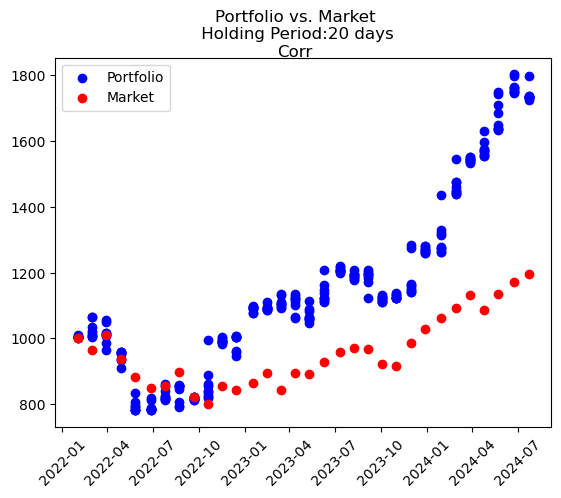

In [937]:
from datetime import datetime
df20=df20.dropna()

totals_20,values_20, dates_20=Invest(df20)
plot_vs_market(df20,values_20,dates_20,holding_period=20) 


In [939]:
print('Average Percent Gain Of Each Porfolio')
for metric in metrics:
    data=df20[df20['Metric']==metric]
    print(f"{metric}: {data['Percent Gain'].mean()*100}")

Average Percent Gain Of Each Porfolio
Slope: 1.1387907864776843
Corr: 0.7411117319817253
Product: 0.7721363869958756


# Use model to predict dates that should not be invest dates.

Summary

Strategy                 Amount Invested          Value after 2.5 years    
Slope                    1000                     1395.903740687647        
Corr                     1000                     1975.62828960268         
Product                  1000                     1290.9810144203786       

Alternative percentage change calculation:


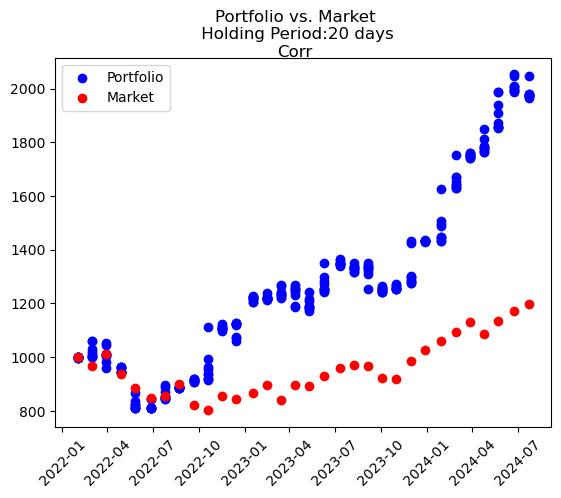

In [933]:
totals_20,values_20, dates_20=Invest(df20,ignore_action=False)
plot_vs_market(df20,values_20,dates_20,holding_period=20)

In [935]:
for metric in metrics:
    data=df20[df20['Metric']==metric]
    data=data[data['Action']]
    print(f"{metric}: {data['Percent Gain'].mean()*100}")

Slope: 1.6575490578819987
Corr: 1.3266268316113756
Product: 1.207865040552995


*Both the portfolio performance and the average percent gain increase after taking out predicted non-invest days*

# Average percent gain for invest and non_invest days

In [944]:
non_invest_days=df20[~df20['Action']]
invest_days=df20[df20['Action']]
print('Average Percent Change (Non Invest Days): ',non_invest_days['Percent Gain'].mean()*100)
print('Average Percent Change (invest_days):', invest_days['Percent Gain'].mean()*100)  

Average Percent Change (Non Invest Days):  -3.3632979355612393
Average Percent Change (invest_days): 1.3963345172222017


# Using more investment days (instead of just every 20 days, invest every day)

In [834]:
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar

class Invest:
    def __init__(self,df,period=20,ignore_action=True):
        self.metrics=['Slope','Corr','Product']
        self.df=df
        self.period=period
        self.ignore_action=ignore_action
        self.portfolio_values=[]
        self.dates=[]
        self.totals, self.initial_investments=self.invest(self.df,period=period,ignore_action=ignore_action)
        self.percent_gains=self.get_percentages()
        self.best_metric=self.get_best()
    def get_best(self):
        max=-float('inf')
        for key, value in self.percent_gains.items():
            if value>max:
                max=value
                metric=key
        return metric
    def get_percentages(self):
        percents={}
        for metric in self.metrics:
            percent=100*(self.totals[metric]-self.initial_investments[metric])/self.initial_investments[metric]
            percents[metric]=percent
        return percents
            
    def add_n_trading_days(self, start_date, n):
        
        """
        Returns the date n trading days after the given start date, considering NYSE holidays.
        
        :param start_date: A pandas Timestamp object or a string that can be converted to a date
        :param n: Number of trading days to add
        :return: A pandas Timestamp object representing the date n trading days later
        """
        nyse = CustomBusinessDay(calendar=USFederalHolidayCalendar())
        # Ensure start_date is a pandas Timestamp
        start_date = pd.Timestamp(start_date)
        
        # Add n trading days
        end_date = start_date + n * nyse
        
        return end_date
        
        return result

        
    def invest(self,DF,period=20,ignore_action=True):
        if ignore_action:
            df=DF.copy()
            df['Action']=True
        else:
            df=DF.copy()
        
        
        D={}
        df['End Date']=pd.to_datetime(df['End Date']).dt.date
        df=df.sort_values(by='End Date')
        dates=df['End Date'].unique()
        stock_percentages={1:34/100, 2: 33/100,3:33/100}
        track=[]
        I={}
        for metric in self.metrics:
            dates_when_available=[None for i in range(21)] #For checking
            investments=[1000/21 for i in range(21)] # 21 investment accounts
            
            total_investment=1000
            for i,date in enumerate(dates):
                j=i%21    #Detrmines the investment acount used
                data=df[(df['Metric']==metric)&(df['End Date']==date)] #Gets all the data for a single date (9 rows)
                dates_when_available[j]=add_n_trading_days(date,period) #Set the date available for the account to the date 20 days later.
                invest=investments[j] #Take the money in the account
                if invest<=0:
                    invest+=investments[(i+1)%20]/2 #If an account is empty take half the money in the account ahead of it.
                    investments[(i+1)%20]-=invest #Reduce the account ahead of it by the amount taken
                    if invest<=0:
                        back_to_zero=abs(invest)
                        invest=invest+back_to_zero+100
                        total_investment+=back_to_zero+100
                investments[j]=0 #Empty the current account as the money is now in an investment.
                schedule=get_breakdown(invest) #Gets the breakdown in which the stocks will be invested in according to rank
                if invest<=0:
                    print('less than 0')
                investments_for_date=0 #Iterate through the rows for a date
             
                for ind, row in data.iterrows():
                    
                    percent_invest_in_stock=stock_percentages[row['Stock_Rank']]
                    invest_in_industry=schedule[row['Industry_Rank']]
                    amount_invested_date_industry=invest_in_industry*percent_invest_in_stock #Amount put into the investment
                    if row['Stock_Metric_Sign'] and row['Action']: #Only invest if the momentum is positive
                        value_add=amount_invested_date_industry*row['Percent Gain'] #Amount gained from the investment in 20 days
                        investments_for_date+=(amount_invested_date_industry+value_add) #Value of the investment 20 days later
                        
                        
                    else:
                        investments_for_date+=amount_invested_date_industry
                       

                investments[j]=investments_for_date # Add the money invested and gained to the account.  
                    
                self.portfolio_values.append(sum(investments))
                self.dates.append(date)
               
            D[metric]=sum(investments) #Get the sum of all the accounts to a dictionary with corresponding metric key.
            I[metric]=total_investment
            
                
                
        return D,I
        
            
    

In [965]:
df20_all['Action'].value_counts()

Action
True     14949
False     2304
Name: count, dtype: int64

**For this data the model is predicting 2304 date/industries that should not be investted in**

# Without invest days model

In [838]:
test_df=df20_all.dropna(subset='Percent Gain')
investments=Invest(test_df)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)




Amount Put In
	 {'Slope': 1000, 'Corr': 1000, 'Product': 1000}

Value of Account
	 {'Slope': 1206.5461978413662, 'Corr': 1084.2513025665196, 'Product': 1179.1486466905087}

Percent Gains
	 {'Slope': 20.654619784136617, 'Corr': 8.42513025665196, 'Product': 17.91486466905087}


# Average Percent Gain

In [946]:
for metric in metrics:
    data=df20_all[df20_all['Metric']==metric]
    print(f"{metric}: {data['Percent Gain'].mean()*100}")

Slope: 0.9309560619001339
Corr: 0.5715191066200841
Product: 0.8239681371598966


# With invest days model

In [872]:
df20_all['End Date']=pd.to_datetime(df20_all['End Date']).dt.date
df_action['Date']=pd.to_datetime(df_action['Date']).dt.date
df20_all['Action']=df20_all.apply(lambda x: get_action4(x['End Date'],x['Industry'],df_action,ticker_cols,action_column='Predicted_Action2'),axis=1)

test_df=df20_all.dropna(subset='Percent Gain')
investments2=Invest(test_df,ignore_action=False)
print('Amount Put In')
print('\t',investments2.initial_investments)
print()
print('Value of Account')
print('\t',investments2.totals)
print()
print('Percent Gains')
print('\t',investments2.percent_gains)

Amount Put In
	 {'Slope': 1000, 'Corr': 1000, 'Product': 1000}

Value of Account
	 {'Slope': 1262.4426156535449, 'Corr': 1222.2564251101007, 'Product': 1257.0979687435486}

Percent Gains
	 {'Slope': 26.244261565354485, 'Corr': 22.225642511010076, 'Product': 25.709796874354854}


# Average Percent Gain After Model

In [949]:
for metric in metrics:
    data=df20[df20['Metric']==metric]
    data=data[data['Action']]
    print(f"{metric}: {data['Percent Gain'].mean()*100}")

Slope: 1.6575490578819987
Corr: 1.3266268316113756
Product: 1.207865040552995


In [970]:
non_invest_days=df20_all[~df20_all['Action']]
invest_days=df20_all[df20_all['Action']]
print('Average Percent Change (Non Invest Days): ',non_invest_days['Percent Gain'].mean()*100)
print('Average Percent Change (invest_days):', invest_days['Percent Gain'].mean()*100)  

Average Percent Change (Non Invest Days):  -1.5834070713736388
Average Percent Change (invest_days): 1.1390424338357885
